# Hedging Commodity Price Risk

Many industrial producers are exposed to commodity price volatility be it on the selling side or on the buying side, or both. Companies therefore seek to smooth out fluctations of the resulting revenues and costs to protect margins and stabilize their bottom line. To achieve this, commodity buyers and sellers have long used hedging with financial derivatives, such as futures, options, and swaps.

In this notebooks, we will take a look at spot prices of a number of precious metals which are common targets of hedging strategies. We will take a look at how to measure and model commodity price volatility as well as how to hedge commodities for which no liquid future market exists.


### Spot Prices of Precious Metals

As our data example, we will use daily closing spot prices of various precious metals from 2016 to 2020. The selected metals are used as input for products across all industries and as such present a good example of commodities that receive significant attention in many procurement organizations.

In [1]:
import pandas as pd
import numpy as np
spot_prices = pd.read_csv("https://lscm.s3.amazonaws.com/machine_learning/spot_prices.csv", index_col=0, parse_dates=True)
spot_prices.index.name = "Date"
spot_prices

,Silver,Gold,Platinum,Palladium,Zinc,Lead,Aluminum,Copper,Cobalt,Steel
Date,,,,,,,,,,
2009-09-30,16.590000,1006.700000,1295.500000,293.500000,15240.00,2.819000,14810.00,47450.0,18.0,3483.0
2009-10-01,16.320000,998.500000,1277.500000,287.500000,15860.00,2.737000,14940.00,49320.0,18.0,3449.0
2009-10-02,16.120000,1001.350000,1278.000000,294.000000,15860.00,2.681500,14940.00,49320.0,17.0,3449.0
2009-10-03,16.276667,1006.483333,1283.000000,295.500000,15860.00,2.696667,14940.00,49320.0,17.0,3449.0
2009-10-04,16.433333,1011.616667,1288.000000,297.000000,15860.00,2.711833,14940.00,49320.0,17.0,3449.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-03,24.946667,1728.706633,1209.233333,2665.576633,21503.75,4.066750,17481.25,66550.0,25.2,4970.0
2021-04-04,24.923333,1728.573267,1208.966667,2665.103267,21592.50,4.103125,17497.50,66820.0,25.2,4980.0
2021-04-05,24.900000,1728.439900,1208.700000,2664.629900,21681.25,4.139500,17513.75,67090.0,25.2,4990.0


#### Indexed Price Development

Let us create a spot price index by dividing all prices by the price at the beginning of the time horizon and then apply the natural logarithm. In this way, we obtain a normalized view of how prices across different commodities have evolved over time.

In [2]:
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_white'
price_index = np.log(spot_prices/spot_prices.iloc[0,:])
px.line(price_index, x=price_index.index, y=price_index.columns)

#### Spot Price Returns

By calculating the percentage changes of successive spot price observations we obtain the spot price returns. As we can see the arithmetic mean of the returns is slightly positve, which means that spot prices exhibit a slight upward drift. This drift reflects the relative growth in value of these commodities against the U.S. Dollar.

In [3]:
spot_returns = spot_prices.pct_change().dropna()
spot_returns.describe()

,Silver,Gold,Platinum,Palladium,Zinc,Lead,Aluminum,Copper,Cobalt,Steel
count,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000,4207.000000
mean,0.000203,0.000160,0.000043,0.000632,0.000121,0.000145,0.000055,0.000114,0.000180,0.000159
std,0.014363,0.007732,0.010636,0.014896,0.008399,0.010819,0.005667,0.007911,0.014289,0.012031
min,-0.149571,-0.057224,-0.112747,-0.205280,-0.053107,-0.073281,-0.047720,-0.082165,-0.304878,-0.174739
25%,-0.004599,-0.002532,-0.004572,-0.005259,-0.002830,-0.004065,-0.001870,-0.002640,0.000000,-0.002455
50%,0.000285,0.000135,0.000055,0.000805,0.000000,0.000072,0.000000,0.000000,0.000000,0.000000
75%,0.005271,0.003155,0.004570,0.006728,0.003376,0.004430,0.002154,0.003250,0.000000,0.002927
max,0.079700,0.047982,0.101946,0.198838,0.044951,0.067644,0.044660,0.054922,0.440000,0.102299


#### Palladium Spot Price Returns

Considering spot price returns for Palladium, its variation does not exhibit noticable systematic patterns, which indicates that the time series is stationary. 

In [4]:
spot_returns

,Silver,Gold,Platinum,Palladium,Zinc,Lead,Aluminum,Copper,Cobalt,Steel
Date,,,,,,,,,,
2009-10-01,-0.016275,-0.008145,-0.013894,-0.020443,0.040682,-0.029088,0.008778,0.039410,0.000000,-0.009762
2009-10-02,-0.012255,0.002854,0.000391,0.022609,0.000000,-0.020278,0.000000,0.000000,-0.055556,0.000000
2009-10-03,0.009719,0.005126,0.003912,0.005102,0.000000,0.005656,0.000000,0.000000,0.000000,0.000000
2009-10-04,0.009625,0.005100,0.003897,0.005076,0.000000,0.005624,0.000000,0.000000,0.000000,0.000000
2009-10-05,0.009533,0.005074,0.003882,0.005051,0.000000,0.005593,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-04-03,-0.000934,-0.000077,-0.000220,-0.000178,0.004144,0.009025,0.000930,0.004074,0.000000,0.002016
2021-04-04,-0.000935,-0.000077,-0.000221,-0.000178,0.004127,0.008944,0.000930,0.004057,0.000000,0.002012
2021-04-05,-0.000936,-0.000077,-0.000221,-0.000178,0.004110,0.008865,0.000929,0.004041,0.000000,0.002008


In [5]:
px.line(spot_returns, x=spot_returns.index, y="Palladium")

#### Autocorrelation of Returns

The autocorrelatio does not appear not to be significant and also does not show any systematic pattern. There is evidence for weak autocorrelation at the first lag for Palladium that can be explained by lower market liquidity which results in slow price adjustment. 

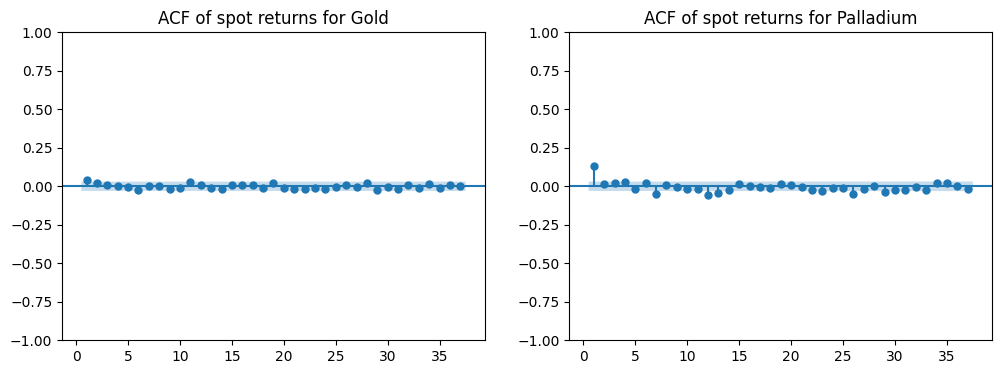

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
_ = plot_acf(spot_returns.Gold, ax=ax1, title="ACF of spot returns for Gold", zero=False)
_ = plot_acf(spot_returns.Palladium, ax=ax2, title="ACF of spot returns for Palladium", zero=False)

#### Autocorrelation of Squared Returns

Although prices are not correlated in time, there is evidence for spot price volatility exhbiting weekly seasonality and autocorrelation that can be explained by variyng degrees of trading activity on different weekdays. We can therefore conclude that spot prices for metal can be reasonably described as a geometric random walk, whereby we might consider modeling volatility of the errors as an autoregressive model (see [autoregressive conditional heteroskedasticity](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)).

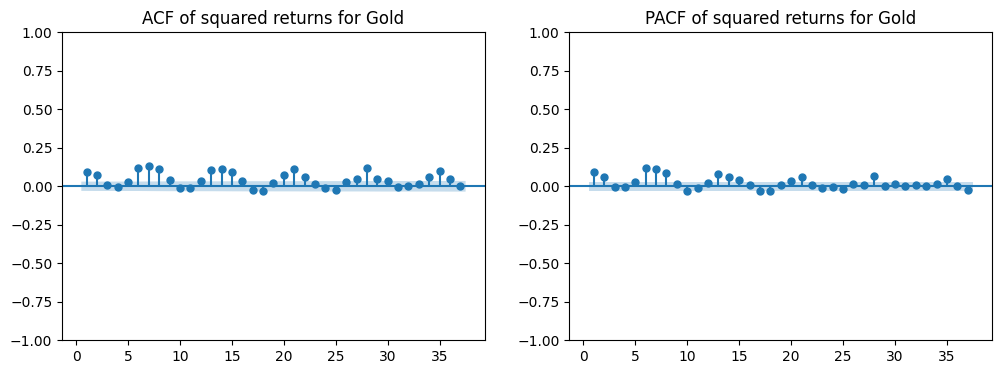

In [7]:
sq_returns = spot_returns**2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
_ = plot_acf(sq_returns.Gold, ax=ax1, title="ACF of squared returns for Gold", zero=False)
_ = plot_pacf(sq_returns.Gold, ax=ax2, title="PACF of squared returns for Gold", zero=False, method="ols")

## Principal Components Analysis

To identify which commodities exhibit similar returns, we can calculate the Pearson correlation coeffient. However, correlation only looks at pairs of features, but does not tell us anything about how returns are jointly related, which is important if we want to create a cross hedging portfolio. To find out which metals represent good candidates for a cross hedge, we are going to use principal components analysis.

### What are principal components?

The commodity prices or their returns are the features in our dataset. Like in most cases, these features are highly correlated with each other. For example, if the price of gold and silver moves up, meaning the return is positive, there is a strong tendency that the price of platinum will move up.

A principal component is like a new feature that is simply a linear function of all the other features, much like in linear regression model. These functions are called *loading vectors*. Suppose we have a loading vector, $w_j$. Then we can express the value of the first principal component of a vector of $p$ features, $x_i$, as

$$z_i = w_{11}x_{i1}+\dots +w_{p1}x_{ip}$$

Unlike regression, however, there is no target vector or response that we use to fit the principal components. Rather, loading vectors describe rotations and expansions in feature space along which the data varies the most.

Take a look at the following two-dimensional dataset. The first principal component is a vector that points in the direction in which the data varies the most. And the second principal component is orthogonal to the first one.


Original Features            |  First Principal Component
:-------------------------:|:-------:
![](https://i.stack.imgur.com/jPw90.png)  |  ![](https://i.stack.imgur.com/lNHqt.gif)

Source: [Stack Exchange - Cross Validated (2011)](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

### How do I find the principal components?

We are looking for $p$ orthogonal loading vectors, where each additional loading vector points in the direction of maximum variance of the data.

If we translate this requirement to an optimization problem, we are looking for a linear function of the features with the largest variance, subject to the constraint that the squared sum of the features cannot exceed $1$. We can express this as the following optimization problem:

$$ \max_{w_{11}x_{i1},\dots,w_{p1}x_{ip}} \left \{ \frac{1}{n}\sum_{i=1}^n\left(\sum_{j=1}^pw_{j1}x_{ij}\right)\Bigg|\sum_{j=1}^p w_{j1}^2 = 1\right\}
$$

The second principal component can be found by solving the same optimization problem, only that the loading vector now must be orthogonal to the first one,

$$ \max_{w_{12}x_{i2},\dots,w_{p1}x_{ip}} \left \{ \frac{1}{n}\sum_{i=1}^n\left(\sum_{j=1}^p w_{j2}x_{ij}\right)\Bigg|\sum_{j=1}^p w_{j2}^2 = 1, \sum_{j=1}^p w_{j1} w_{j2} = 0 \right\}
$$

Each additional principal component needs to be orthogonal to the first one.

### Singular Value Decomposition

We can solve the above problem using eigenvalue decomposition (EVD) or singular value decomposition (SVD). Since SVD is commonly used in machine learning, we are going to briefly discuss SVD.

In a nutshell, SVD is a method of decomposing a matrix into three other matrices. For a given feature matrix $X$, SVD decomposes it into a product of three matrices $U$, $\Sigma$, and $V'$ (where $V'$ is the transpose of $V$),
$$
X= U \Sigma V'
$$

The principal components of the data are given by the columns of $V$. The square of the diagonal entries of $\Sigma$ give the variance explained by each principal component.

To calculate the transformed matrix $Z$, we simple multiply it with V,

$$Z = XV,$$

so that the first two columns of $Z$ give us the values along the first two principal components.

It's worth noting that before performing PCA with SVD, it's common to standardize the data to have zero mean and unit standard deviations.

### What is the benefit of principal components?

Principal components have a number of interesting properties that are useful for data analysis and machine learning.

#### Data Transformation

Unlike the original features, all principal components are independent of one another. The second principal component in the above animation is drawn as a gray line that is orthogonal to the red line. This means that the principal components create their own system of cooordinates. Just think of the first principal components as the new x-axis and the second principal component as the new y-axis. 

#### Dimensionality Reduction

Principal components are ordered by the amount of variance that each of them explains. This means that the first principal component explains more variance than the second and so on. This means, that we can use principal components for dimensionality reduction. For example, we can reduce the two-dimensional data shown above to one dimension by replacing the blue points with the red points. As we will see, the first two principal components of the spot returns data explain more than 50% of the variability in the original data.

#### Reconstructing Data 

We can use the new features described by the principal components to reconstruct the old features. But we can also use only the first one or two principal components to reconstruct the original features. The red dots in the animation show the projection of the old points into the feature space spanned by the first principal component. The reconstruction error is shown by the red lines that connect the blue and the red dots. Together with the second component the data could be reconstructed perfectly.

#### Uncovering Latent Factors 

We can use the principal components to infer missing values by iteratively reconstructing the unknown values with their low-dimensional projection. This trick is mathematically related to matrix factorization techniques often used in recommender systems, which aim at reconstructing a sparse (empty) matrix from a number of known relationships, for example product ratings of users.

## Cross Hedging

The purpose of cross hedging is to hedge the price of a commodity for which there are no future prices (or where the futures market is not very liquid). This is clearly the case for Palladium when compared to Gold, Silver, or Platinum.

#### Standardization

Before any PCA we must standize the values along each dimension. A standard approach to do this is normalization which means we divide the returns by their standard deviation. 

In [8]:
from sklearn.preprocessing import StandardScaler
X = spot_returns.values
X_std = StandardScaler().fit_transform(X)

#### Calculating the PCA
We then perform PCA on the standardized returns. As we will only inspect the first two components, we fit a PCA with `n_components=2`.

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
_ = pca.fit(X_std)

#### Loading Vectors

Let us take a look at the loading vectors of each principal component, which we are going to use later to project the multi-dimensional returns data onto a two-dimensional plane.

In [10]:
pd.DataFrame(pca.components_, columns=spot_returns.columns)

,Silver,Gold,Platinum,Palladium,Zinc,Lead,Aluminum,Copper,Cobalt,Steel
0,-0.454545,-0.414296,-0.453627,-0.390595,-0.232939,-0.329400,-0.195056,-0.241281,-0.010061,-0.065391
1,0.228137,0.250211,0.196443,0.143087,-0.516742,0.008767,-0.480637,-0.522766,0.024167,-0.233033


#### Variance Explained

In addition, the PCA also gives us the variance explained by each principal component. In this case, the first two principal components explain a little more than 50% of the variance.

In [12]:
pca.explained_variance_ratio_

array([0.31891682, 0.21847728])

#### Loading Plot of Spot Returns

Let us take a look at the so-called *loading plot* which simply plots the axes coordinates of the original data into the rotated coordinate system that is defined by the first two components. For our use case of hedging, the loading plot helps us to identify spot prices that jointly move in the same direction.

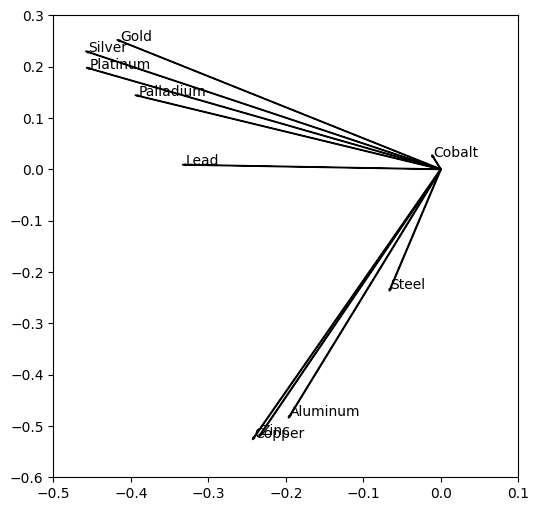

In [11]:
_, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlim(-0.5,0.1)
ax.set_ylim(-0.6,0.3)
comp = pca.components_
for i in range(X.shape[1]):
    ax.arrow(0,0,comp[0][i],comp[1][i])
    ax.text(comp[0][i],comp[1][i],spot_prices.columns[i])
plt.show()

#### Exercise

Given the above loading plot, which commodities would mark a suitable cross hedge for zinc? Which ones for cobalt?

### Futures Prices of Selected Metals

To hedge the price of Palladium, we are going to use futures contracts of other commodities whose returns are closely related to the returns of Palladium. For our example, we will use the M1 futures of Gold, Silver, and Platinum, all of which possess highly liquid futures markets.

In [13]:
futures_prices = pd.read_csv("https://lscm.s3.amazonaws.com/machine_learning/futures_prices.csv", index_col=0, parse_dates=True)
prices = (spot_prices[["Palladium"]]
    .join(futures_prices)
    .dropna()
)
prices

,Palladium,Gold M1,Silver M1,Platinum M1
Date,,,,
2016-01-04,539.1000,1075.100,13.81700,883.20
2016-01-05,534.3100,1078.400,13.94900,888.60
2016-01-06,507.7500,1091.900,13.95700,873.70
2016-01-07,492.2500,1107.700,14.33500,876.40
2016-01-08,494.2000,1097.800,13.90800,877.10
...,...,...,...,...
2020-12-27,2332.2233,1877.875,26.29775,1038.65
2020-12-28,2323.7700,1877.200,26.46000,1042.20
2020-12-29,2327.6477,1879.700,26.13800,1055.70


#### Indexed Price Development

A look at the indexed spot and futures prices illustrates that there is a strong relationship between the selected futures prices and the spot price for Palladium.

In [14]:
price_index = np.log(prices/prices.iloc[0,:])
px.line(price_index, x=price_index.index, y=price_index.columns)

### Creating a Cross Hedge

A cross-hedge for Palladium can be calculated by regressing the spot price of Palladium on the selected futures prices. What is important is that the regression cannot have an intercept term.

In [15]:
from sklearn.linear_model import LinearRegression
X = prices.drop(["Palladium"], axis=1)
y = prices["Palladium"]
lr = LinearRegression(fit_intercept=False)
lr.fit(X,y)
print("R2:",lr.score(X,y))

R2: 0.8297552357392024


#### Cross Hedge Portfolio

The nominal weight of each future contracts in the cross hedge can be obtained by looking at the corresponding regression coefficient. It should be noted that the weights of the cross hedge should be readjusted periodically, for example every month or every year. To this end, it may be useful to calculate weights by using a rolling time window over the past five years, say, instead of using all available historical data.

In [16]:
weights = lr.coef_
pd.DataFrame(lr.coef_, index=X.columns, columns=["weight"])

,weight
Gold M1,2.479240
Silver M1,-30.425925
Platinum M1,-1.816009


#### Development of the Cross Hedge

Let us compare the evolution of the cross hedge against the actualy spot price. Although the cross hedge is able to track the evolution of the spot price, there still remains basis risk that cannot be hedged. In practice, it is therefore important to have a mitigation strategy for the basis risk to account for the situation when the cross hedge decouples from the spot price to whom it ought to be pegged.

In [17]:
prices["Cross Hedge"] = lr.predict(X)
px.line(prices, x=prices.index, y=["Palladium","Cross Hedge"])

## Optional: Monte Carlo Simulation

#### Pseudo-random Returns

- Log-normal distribution: $\mathbb{E}[X]=\exp(\mu+\sigma^2/2)$

- Zero drift: $\mathbb{E}[X] = 1 \Rightarrow \mu+\sigma^2/2 = 0 \Rightarrow \mu=-\sigma^2/2$

In [18]:
n, p = spot_returns.shape
n_sim = 365
sim_returns = np.exp(
    np.random.multivariate_normal(mean=spot_returns.mean()-spot_returns.var()/2.0, 
                                  cov=spot_returns.cov(), 
                                  size=n_sim)
)
pd.DataFrame(sim_returns-1).describe()

,0,1,2,3,4,5,6,7,8,9
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,-0.000490,-0.000111,-0.000025,0.001584,0.000188,-0.000768,-0.000080,0.000073,0.000007,0.001070
std,0.015180,0.008554,0.012084,0.015726,0.008166,0.010886,0.005447,0.008065,0.014923,0.012954
min,-0.036904,-0.024185,-0.027665,-0.035399,-0.023427,-0.034541,-0.014131,-0.025074,-0.047164,-0.031060
25%,-0.010959,-0.006105,-0.008344,-0.009201,-0.005551,-0.008188,-0.003379,-0.005382,-0.009686,-0.007325
50%,-0.000997,-0.000071,0.000190,0.001646,0.000425,-0.001168,-0.000249,0.000144,0.000840,0.000962
75%,0.009479,0.005989,0.009570,0.012260,0.005552,0.006212,0.003565,0.005118,0.009318,0.008024
max,0.039022,0.024065,0.037047,0.051455,0.024288,0.036920,0.012643,0.024081,0.046563,0.054893


#### Simulated Time Horizon

In [19]:
last_price = spot_prices.iloc[-1]
start_date = last_price.name
end_date = start_date+pd.Timedelta(days=n_sim)
index = pd.date_range(start=start_date, end=end_date, freq="D")
index

DatetimeIndex(['2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10',
               '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14',
               '2021-04-15', '2021-04-16',
               ...
               '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01',
               '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05',
               '2022-04-06', '2022-04-07'],
              dtype='datetime64[ns]', length=366, freq='D')

#### Pseudo-random Spot Prices

In [ ]:
sim_prices = pd.DataFrame(index=index, columns=spot_prices.columns, dtype=np.float64)
sim_prices.iloc[0] = spot_prices.iloc[-1].values
sim_prices.iloc[1:] = sim_returns
sim_prices = sim_prices.cumprod() #inverse of pct_change

#### Indexed Simulated Prices

In [ ]:
price_index = np.log(sim_prices/sim_prices.iloc[0,:])
px.line(price_index, x=price_index.index, y=price_index.columns)